In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, GlobalAveragePooling2D
import warnings
warnings.filterwarnings('ignore')

2024-02-25 16:57:13.772367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 16:57:13.772512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 16:57:13.945931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define the path to your dataset
data_path_train = "/kaggle/input/multiclass-lungs-x-rays/Multiclass Lung disease/Train"
data_path_val="/kaggle/input/multiclass-lungs-x-rays/Multiclass Lung disease/Val"
# Specify parameters
img_size = (256, 256)
batch_size = 32

# Use ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Create generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    data_path_train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)
validation_generator = val_datagen.flow_from_directory(
    data_path_val,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2743 images belonging to 5 classes.
Found 853 images belonging to 5 classes.


In [3]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Bacterial Pneumonia
1 : Corona Virus Disease
2 : Normal
3 : Tuberculosis
4 : Viral Pneumonia


In [5]:
from tensorflow.keras.optimizers import RMSprop, Adam
# Load the VGG16 model pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(train_generator.num_classes, activation='softmax'))
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
history=model.fit(train_generator,epochs=15,validation_data=validation_generator)

Epoch 1/15


I0000 00:00:1708880313.782113     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 [==============================] - 131s 1s/step - loss: 0.7953 - accuracy: 0.7193 - val_loss: 0.6764 - val_accuracy: 0.7655
Epoch 2/15
86/86 [==============================] - 90s 1s/step - loss: 0.5137 - accuracy: 0.7929 - val_loss: 0.6196 - val_accuracy: 0.7655
Epoch 3/15
86/86 [==============================] - 89s 1s/step - loss: 0.4665 - accuracy: 0.8166 - val_loss: 0.5631 - val_accuracy: 0.7972
Epoch 4/15
86/86 [==============================] - 89s 1s/step - loss: 0.4185 - accuracy: 0.8327 - val_loss: 0.5202 - val_accuracy: 0.8077
Epoch 5/15
86/86 [==============================] - 88s 1s/step - loss: 0.3940 - accuracy: 0.8385 - val_loss: 0.5256 - val_accuracy: 0.7831
Epoch 6/15
86/86 [==============================] - 89s 1s/step - loss: 0.3785 - accuracy: 0.8494 - val_loss: 0.4832 - val_accuracy: 0.8218
Epoch 7/15
86/86 [==============================] - 89s 1s/step - loss: 0.3338 - accuracy: 0.8666 - val_loss: 0.4843 - val_accuracy: 0.8148
Epoch 8/15
86/86 [============

In [7]:
model.save("Multiclass_class_inceptionv3.h5")

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)
data_path_test="/kaggle/input/multiclass-lungs-x-rays/Multiclass Lung disease/Test"
test_generator = test_datagen.flow_from_directory(
    data_path_test,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

# Evaluate the model on the test set
results = model.evaluate(test_generator)

# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

Found 650 images belonging to 5 classes.
21/21 [==============================] - 16s 802ms/step - loss: 0.4085 - accuracy: 0.8477
Test Loss: 0.4085235595703125
Test Accuracy: 0.8476923108100891


In [9]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred, target_names=labels.values()))

21/21 [==============================] - 10s 433ms/step
                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.73      0.69      0.71       130
Corona Virus Disease       0.99      0.93      0.96       130
              Normal       0.85      0.95      0.90       130
        Tuberculosis       0.96      1.00      0.98       130
     Viral Pneumonia       0.70      0.67      0.68       130

            accuracy                           0.85       650
           macro avg       0.85      0.85      0.85       650
        weighted avg       0.85      0.85      0.85       650



21/21 [==============================] - 9s 433ms/step


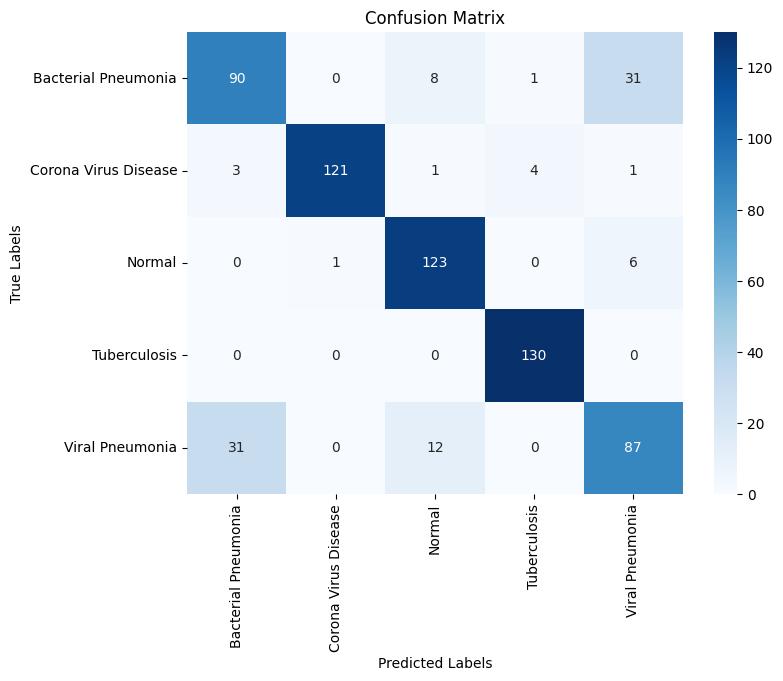

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels
true_labels = test_generator.classes

# Predict the labels using the model
predictions = model.predict(test_generator)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

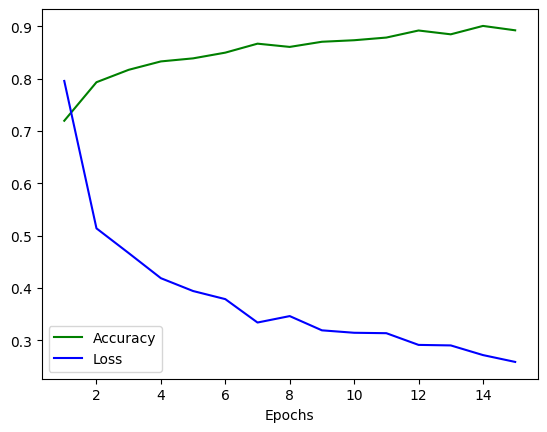

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(1,16),history.history['accuracy'],color='g',label='Accuracy')
plt.plot(range(1,16),history.history['loss'],color='blue',label='Loss')
plt.xlabel('Epochs')
plt.legend()

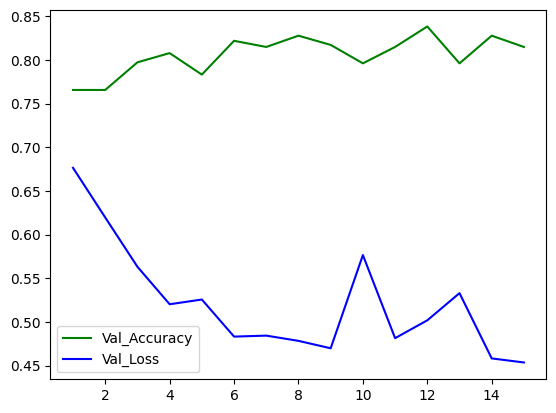

In [21]:
plt.plot(range(1,16),history.history['val_accuracy'],color='g',label='Val_Accuracy')
plt.plot(range(1,16),history.history['val_loss'],color='b',label='Val_Loss')
plt.legend()

1/1 [==============================] - 0s 28ms/step
Original Prediction: Corona Virus Disease


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


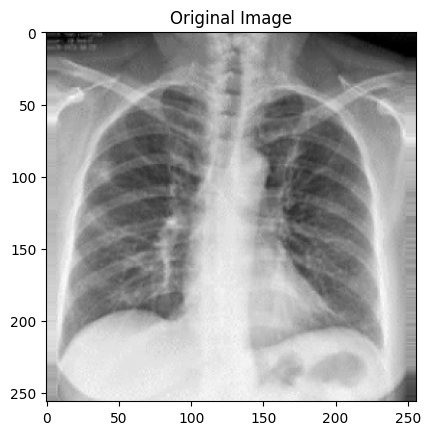

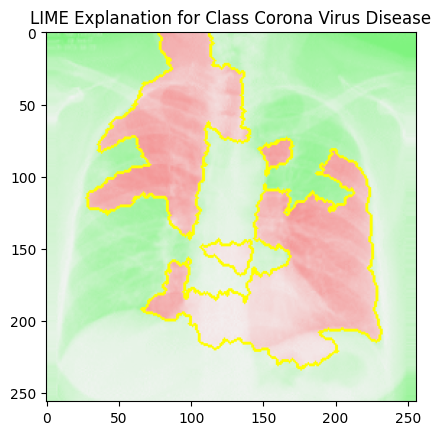

In [17]:
import lime
from lime import lime_image
from keras.models import load_model
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries

# Load the trained multiclass model
#model = load_model("your_multiclass_model.h5")  # Replace with the actual path to your model

# Define a custom segmentation algorithm
#segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

# Create a LIME explainer with the custom segmentation algorithm
explainer = lime_image.LimeImageExplainer()

# Load and preprocess an image for LIME interpretation
img_for_lime, _ = validation_generator.next()  # Load an example image from the validation set
img_for_lime = img_for_lime[0]  # Take the first image from the batch

# Add a dummy RGB channel to the grayscale image
img_for_lime_rgb = np.stack((img_for_lime[:, :, 0],) * 3, axis=-1)

# Get the original prediction
original_prediction = model.predict(np.expand_dims(img_for_lime, axis=0))
print("Original Prediction:", labels[np.argmax(original_prediction)])

# Explain the prediction using LIME for top three classes with custom segmentation
explanation = explainer.explain_instance(
    img_for_lime_rgb,
    model.predict,
    top_labels=1,  # Specify the number of top classes for explanation
    hide_color=0,
    num_samples=1000
)

# Display the original image
plt.imshow(img_for_lime[:, :, 0], cmap='gray')  # Assuming images are grayscale
plt.title('Original Image')
plt.show()

# Display the LIME explanation for the top three predictions
for label in explanation.top_labels:
    temp, mask = explanation.get_image_and_mask(
        label,
        positive_only=False,
        num_features=img_size[0],  # Specify based on your image dimensions
        hide_rest=False
    )
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f'LIME Explanation for Class {labels[label]}')
    plt.show()


1/1 [==============================] - 0s 27ms/step
Original Prediction: Normal


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


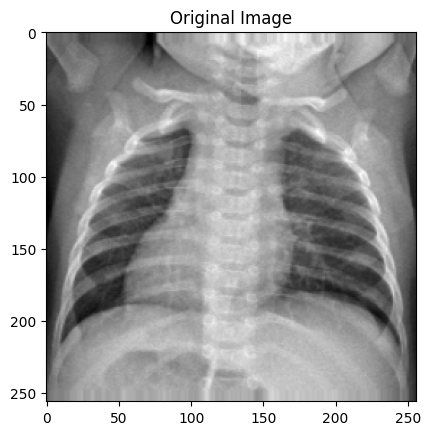

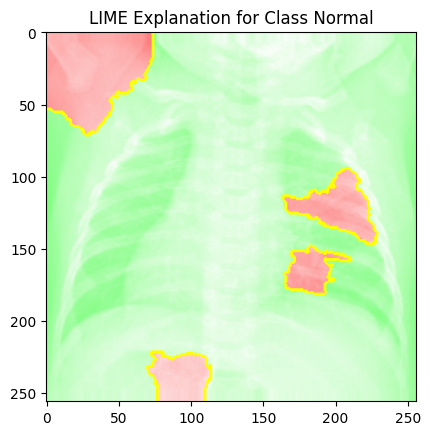

In [18]:
import lime
from lime import lime_image
from keras.models import load_model
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries

# Load the trained multiclass model
#model = load_model("your_multiclass_model.h5")  # Replace with the actual path to your model

# Define a custom segmentation algorithm
#segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

# Create a LIME explainer with the custom segmentation algorithm
explainer = lime_image.LimeImageExplainer()

# Load and preprocess an image for LIME interpretation
img_for_lime, _ = validation_generator.next()  # Load an example image from the validation set
img_for_lime = img_for_lime[0]  # Take the first image from the batch

# Add a dummy RGB channel to the grayscale image
img_for_lime_rgb = np.stack((img_for_lime[:, :, 0],) * 3, axis=-1)

# Get the original prediction
original_prediction = model.predict(np.expand_dims(img_for_lime, axis=0))
print("Original Prediction:", labels[np.argmax(original_prediction)])

# Explain the prediction using LIME for top three classes with custom segmentation
explanation = explainer.explain_instance(
    img_for_lime_rgb,
    model.predict,
    top_labels=1,  # Specify the number of top classes for explanation
    hide_color=0,
    num_samples=1000
)

# Display the original image
plt.imshow(img_for_lime[:, :, 0], cmap='gray')  # Assuming images are grayscale
plt.title('Original Image')
plt.show()

# Display the LIME explanation for the top three predictions
for label in explanation.top_labels:
    temp, mask = explanation.get_image_and_mask(
        label,
        positive_only=False,
        num_features=img_size[0],  # Specify based on your image dimensions
        hide_rest=False
    )
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f'LIME Explanation for Class {labels[label]}')
    plt.show()
